In [1]:
from google.colab import drive
drive.mount('/content/drive')

#loading the dataset and extracting from the zip file
!unzip drive/My\ Drive/FOLD3_1000.zip
#installing relevent modules for resnet34 model
!pip install git+https://github.com/qubvel/classification_models.git

Streaming output truncated to the last 5000 lines.
  inflating: FOLD3/Validation/Epithelioid/TCGA-UD-AABZ-01A-01-TSA.D27382EA-A48E-45C3-B017-9B8E8C7B5F13.svs/71847-15079.jpg  
  inflating: FOLD3/Validation/Epithelioid/TCGA-UD-AABZ-01A-01-TSA.D27382EA-A48E-45C3-B017-9B8E8C7B5F13.svs/70073-14192.jpg  
  inflating: FOLD3/Validation/Epithelioid/TCGA-UD-AABZ-01A-01-TSA.D27382EA-A48E-45C3-B017-9B8E8C7B5F13.svs/62977-16853.jpg  
  inflating: FOLD3/Validation/Epithelioid/TCGA-UD-AABZ-01A-01-TSA.D27382EA-A48E-45C3-B017-9B8E8C7B5F13.svs/15079-29271.jpg  
  inflating: FOLD3/Validation/Epithelioid/TCGA-UD-AABZ-01A-01-TSA.D27382EA-A48E-45C3-B017-9B8E8C7B5F13.svs/63864-13305.jpg  
  inflating: FOLD3/Validation/Epithelioid/TCGA-UD-AABZ-01A-01-TSA.D27382EA-A48E-45C3-B017-9B8E8C7B5F13.svs/64751-10644.jpg  
  inflating: FOLD3/Validation/Epithelioid/TCGA-UD-AABZ-01A-01-TSA.D27382EA-A48E-45C3-B017-9B8E8C7B5F13.svs/73621-18627.jpg  
  inflating: FOLD3/Validation/Epithelioid/TCGA-UD-AABZ-01A-01-TSA.D27382EA

In [2]:
!unzip drive/My\ Drive/Test_1000.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Test_1000/Epithelioid/TCGA-MQ-A6BS-01A-01-TSA.97507899-584F-4120-AE05-217075217583.svs/._74949-09933.jpg  
  inflating: Test_1000/Epithelioid/TCGA-MQ-A6BS-01A-01-TSA.97507899-584F-4120-AE05-217075217583.svs/80367-17157.jpg  
  inflating: __MACOSX/Test_1000/Epithelioid/TCGA-MQ-A6BS-01A-01-TSA.97507899-584F-4120-AE05-217075217583.svs/._80367-17157.jpg  
  inflating: Test_1000/Epithelioid/TCGA-MQ-A6BS-01A-01-TSA.97507899-584F-4120-AE05-217075217583.svs/11739-07224.jpg  
  inflating: __MACOSX/Test_1000/Epithelioid/TCGA-MQ-A6BS-01A-01-TSA.97507899-584F-4120-AE05-217075217583.svs/._11739-07224.jpg  
  inflating: Test_1000/Epithelioid/TCGA-MQ-A6BS-01A-01-TSA.97507899-584F-4120-AE05-217075217583.svs/76755-19866.jpg  
  inflating: __MACOSX/Test_1000/Epithelioid/TCGA-MQ-A6BS-01A-01-TSA.97507899-584F-4120-AE05-217075217583.svs/._76755-19866.jpg  
  inflating: Test_1000/Epithelioid/TCGA-MQ-A6BS-01A-01-TSA.97507899-584F-4120-A

In [4]:
#related modules 
import keras
import numpy as np
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from classification_models.keras import Classifiers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve,auc
from sklearn.metrics import average_precision_score
import tensorflow as tf
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
import os
import glob
import pandas as pd
from fnmatch import fnmatch

In [8]:
train_path = "FOLD3/Train"
val_path = "FOLD3/Validation"
test_path ="Test_1000"

batch_size = 64

loss_function ='categorical_crossentropy'
patience = 10
epoch = 50
final_activation ='softmax'
file_pattern = "*.jpg"
folder_pattern = "*TCGA-*"


Resnet18_model,preprocess_input = Classifiers.get('resnet18')
base_resnet18model = Resnet18_model(input_shape=(224,224,3), weights='imagenet', include_top=False)
base_resnet18model.summary()

#reading train and validation data
data_generator = ImageDataGenerator(rescale = 1./255,preprocessing_function=  preprocess_input)
#loop and iterating through train images
train_data_generator = data_generator.flow_from_directory(train_path,class_mode ='categorical',batch_size = batch_size,target_size = (224,224),shuffle =True)
#iterating through images of validation set
val_data_generator = data_generator.flow_from_directory(val_path,class_mode ='categorical',batch_size = batch_size,target_size = (224,224),shuffle = True)
#class wight balance

#class wight balance
# classes = train_data_generator.classes
class_weights_list = class_weight.compute_class_weight('balanced',np.unique(train_data_generator.classes),train_data_generator.classes)
weights = dict(zip(np.unique(train_data_generator.classes),class_weights_list))
print("weights ratio to make the dataset balanced: ",weights)

print("class Indices of train generator :",train_data_generator.class_indices)
print("class Indices of validation generator :",val_data_generator.class_indices)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_18[0][0]          
_______________________________________________________________________________________

In [6]:
def training_model(pretrained_model,final_activation):
    model = Sequential()
    model.add(pretrained_model) #pretrained model
    model.add(Flatten()) #creating a single 1-d vector
    model.add(Dense(2,activation=final_activation))#output layer with softmax activation function.
    return model

#this function takes the each patch in WSI then predicts the probability score
def pred_each_patch(path,name):
    y = image.load_img(os.path.join(path, name))
    img = image.img_to_array(y)
    y = np.expand_dims(img, axis = 0)
    y = preprocess_input(y)
    y /= 255
    y_pred = model.predict(y)
    return y_pred
        
def avg(predlist):
    average = sum(predlist)/len(predlist)
    return average

def extract_index_one_frmpred(prediction_list):               
    ypred = np.stack(prediction_list)#we are vertically stacking the predictions
    ypred = np.reshape(ypred, [len(prediction_list),2])#reshaping to 100,2 - np array
    for each in ypred:
    #after reshaping the predictions as we wanted, we are taking the index '1' to compute whole slide level AUC-ROC
        val = each[1]
        pred_prob_list.append(val)#appending all the values into a list - to compute average values of single WSI and maximum of single WSI.
        
    return pred_prob_list
    
def plt_history(history): 
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.tight_layout() 
    plt.show()
    return

def y_labels(path):
  if "Epithelioid" in path:
    y_test_labels.append(0.0)
  elif "Nonepithelioid" in path:
    y_test_labels.append(1.0) 
  return

def prediction_scores(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS):
  #AUC - ROC score
  false_pr_avg,true_pr_avg,threshold = roc_curve(y_test_labels,AVG_LIST_PREDICTIONS)
  roc_auc_avg = auc(false_pr_avg,true_pr_avg)
  print("AUC - ROC on Test data average prediction scores:",roc_auc_avg)
  print("-----------------------------------------------------")
  plt.plot(false_pr_avg,true_pr_avg,color='green',label='ROC curve on test data(area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title('ROC curve on Test data (area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()
  
  false_pr_max,true_pr_max,threshold = roc_curve(y_test_labels,MAX_LIST_PREDICTIONS)
  roc_auc_max = auc(false_pr_max,true_pr_max)
  print("AUC - ROC on Test data maximum prediction scores:",roc_auc_max)
  print("-----------------------------------------------------")
  plt.plot(false_pr_max,true_pr_max,color='magenta',label='ROC curve on test data(area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title('ROC curve on Test data (area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()
 

def pre_recall(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS):
  #presicion - recall curve
  precision, recall, threshold = precision_recall_curve(y_test_labels,AVG_LIST_PREDICTIONS)
  print("Presicion - Recall auc on test data average score predictions:",auc(recall,precision))
 
  print("-----------------------------------------------------")
  plt.plot(precision, recall,color='orange',label='PR curve (area = %0.2f)' %(auc(recall,precision)))
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title('Presicion Recall curve on Test data (area = %0.2f)' %(auc(recall,precision)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()

  precision_max, recall_max, threshold = precision_recall_curve(y_test_labels,MAX_LIST_PREDICTIONS)
  print("Presicion - Recall auc on test data maximum score predictions:",auc(recall_max,precision_max))
 
  print("-----------------------------------------------------")
  plt.plot(precision_max, recall_max,color='cyan',label='PR curve (area = %0.2f)' %(auc(recall_max,precision_max)))
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title('Presicion Recall curve on Test data (area = %0.2f)' %(auc(recall_max,precision_max)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()

Epoch 1/50
1107/1107 [==============================] - 243s 220ms/step - loss: 0.5097 - auc_1: 0.8743 - precision_1: 0.7890 - recall_1: 0.7890 - val_loss: 1.3069 - val_auc_1: 0.7495 - val_precision_1: 0.7054 - val_recall_1: 0.7054
Epoch 2/50
1107/1107 [==============================] - 234s 212ms/step - loss: 0.1864 - auc_1: 0.9792 - precision_1: 0.9256 - recall_1: 0.9256 - val_loss: 1.3268 - val_auc_1: 0.7084 - val_precision_1: 0.6492 - val_recall_1: 0.6492
Epoch 3/50
1107/1107 [==============================] - 232s 210ms/step - loss: 0.1066 - auc_1: 0.9924 - precision_1: 0.9592 - recall_1: 0.9592 - val_loss: 1.6721 - val_auc_1: 0.7246 - val_precision_1: 0.6759 - val_recall_1: 0.6759
Epoch 4/50
1107/1107 [==============================] - ETA: 0s - loss: 0.0757 - auc_1: 0.9959 - precision_1: 0.9727 - recall_1: 0.9727
Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
1107/1107 [==============================] - 230s 208ms/step - loss: 0.0757 - auc_1: 0.9

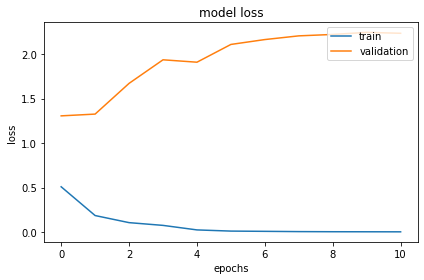

In [9]:
from keras.models import load_model

model = training_model(base_resnet18model,final_activation)  

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor = 0.1,patience=3,verbose = 1)
# early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss',verbose=1, patience=patience)

opt_nadam = tf.keras.optimizers.Nadam(1e-4)#Adam with Nestrov momentum

model.compile(optimizer= opt_nadam, loss=loss_function,metrics = [tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

#Initilaising the model
history = model.fit(train_data_generator, steps_per_epoch=len(train_data_generator.classes)//batch_size, validation_data=val_data_generator,epochs = epoch,class_weight = weights,callbacks =[es,reduce_lr],workers = 4)
    
plt_history(history)#model_loss_plot 

**MODEL EVALUATION ON VALIDATION DATA**

In [10]:
AVG_LIST_PREDICTIONS_VAL = []
MAX_LIST_PREDICTIONS_VAL = []
y_val_labels= []
print("Prediction on validation data using aggregation method")
for path, subdirs, files in os.walk(val_path): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        # print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        if "Epithelioid" in path:
          y_val_labels.append(0.0)
        elif "Nonepithelioid" in path:
          y_val_labels.append(1.0) 

        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        #This list contains average score of all 36 test set images
        AVG_LIST_PREDICTIONS_VAL.append(avg(predictions))
        MAX_LIST_PREDICTIONS_VAL.append(max(predictions))

Prediction on validation data using aggregation method


In [11]:
#creating a datframe to save predictions with actuals
df_val = pd.DataFrame()
df_val['Average'] = AVG_LIST_PREDICTIONS_VAL
df_val['Maximum'] = MAX_LIST_PREDICTIONS_VAL
df_val['Actual labels'] = y_val_labels
#saving into csv file for futher use
df_val.to_csv('FOLD3_1000_res18_val.csv',index = False,header = True)
!cp FOLD3_1000_res18_val.csv "drive/My Drive/"

AUC - ROC on validation data average prediction scores: 0.7366071428571428
-----------------------------------------------------


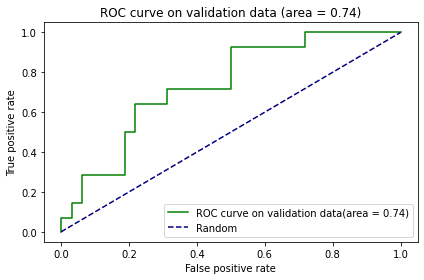

In [12]:
false_pr_avg,true_pr_avg,threshold = roc_curve(y_val_labels,AVG_LIST_PREDICTIONS_VAL)
roc_auc_avg = auc(false_pr_avg,true_pr_avg)
print("AUC - ROC on validation data average prediction scores:",roc_auc_avg)
print("-----------------------------------------------------")
plt.plot(false_pr_avg,true_pr_avg,color='green',label='ROC curve on validation data(area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on validation data (area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

AUC - ROC on validation data maximum prediction scores: 0.7366071428571428
-----------------------------------------------------


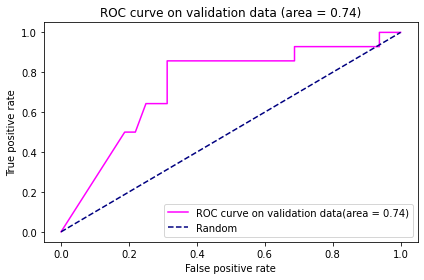

In [13]:
false_pr_max,true_pr_max,threshold = roc_curve(y_val_labels,MAX_LIST_PREDICTIONS_VAL)
roc_auc_max = auc(false_pr_max,true_pr_max)
print("AUC - ROC on validation data maximum prediction scores:",roc_auc_max)
print("-----------------------------------------------------")
plt.plot(false_pr_max,true_pr_max,color='magenta',label='ROC curve on validation data(area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on validation data (area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

Presicion - Recall auc on validation data average score predictions: 0.5260026809360812
-----------------------------------------------------


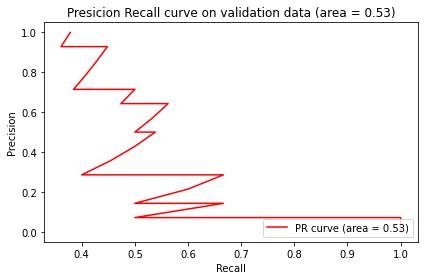

Presicion - Recall auc on validation data maximum score predictions: 0.615703187489956
-----------------------------------------------------


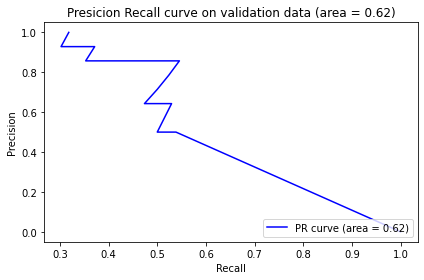

In [14]:
#presicion - recall curve
precision, recall, threshold = precision_recall_curve(y_val_labels,AVG_LIST_PREDICTIONS_VAL)
print("Presicion - Recall auc on validation data average score predictions:",auc(recall,precision))
 
print("-----------------------------------------------------")
plt.plot(precision, recall,color='red',label='PR curve (area = %0.2f)' %(auc(recall,precision)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on validation data (area = %0.2f)' %(auc(recall,precision)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

precision_max, recall_max, threshold = precision_recall_curve(y_val_labels,MAX_LIST_PREDICTIONS_VAL)
print("Presicion - Recall auc on validation data maximum score predictions:",auc(recall_max,precision_max))
print("-----------------------------------------------------")
plt.plot(precision_max, recall_max,color='blue',label='PR curve (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on validation data (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [15]:
import sklearn
#classification report on average prediction values
AVG_LIST_PREDICTIONS_VAL = [round(x) for x in AVG_LIST_PREDICTIONS_VAL]
print("CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS")
print(sklearn.metrics.classification_report(y_val_labels,AVG_LIST_PREDICTIONS_VAL))

CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.73      0.94      0.82        32
         1.0       0.60      0.21      0.32        14

    accuracy                           0.72        46
   macro avg       0.67      0.58      0.57        46
weighted avg       0.69      0.72      0.67        46



In [16]:
#classification report on maximum prediction values
MAX_LIST_PREDICTIONS_VAL = [round(x) for x in MAX_LIST_PREDICTIONS_VAL]
print("CLASSIFICATION REPORT for MAXIMUM SCORE PREDICTIONS")
print(sklearn.metrics.classification_report(y_val_labels,MAX_LIST_PREDICTIONS_VAL))

CLASSIFICATION REPORT for MAXIMUM SCORE PREDICTIONS
              precision    recall  f1-score   support

         0.0       1.00      0.03      0.06        32
         1.0       0.31      1.00      0.47        14

    accuracy                           0.33        46
   macro avg       0.66      0.52      0.27        46
weighted avg       0.79      0.33      0.19        46



**EVALUATION ON TESTDATA**

In [17]:
AVG_LIST_PREDICTIONS = []
MAX_LIST_PREDICTIONS = []
y_test_labels= []
print("Prediction on test using aggregation method")
for path, subdirs, files in os.walk(test_path): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        # print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        y_labels(path)

        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        #This list contains average score of all 36 test set images
        AVG_LIST_PREDICTIONS.append(avg(predictions))
        MAX_LIST_PREDICTIONS.append(max(predictions))

Prediction on test using aggregation method


In [18]:
#creating a datframe to save predictions with actuals
df = pd.DataFrame()
df['Average'] = AVG_LIST_PREDICTIONS
df['Maximum'] = MAX_LIST_PREDICTIONS
df['Actual labels'] = y_test_labels
#saving into csv file for futher use
df.to_csv('FOLD3_1000_res18_test.csv',index = False,header = True)
!cp FOLD3_1000_res18_test.csv "drive/My Drive/"

AUC - ROC on Test data average prediction scores: 0.7654320987654322
-----------------------------------------------------


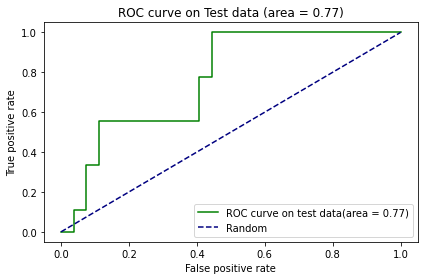

AUC - ROC on Test data maximum prediction scores: 0.6399176954732511
-----------------------------------------------------


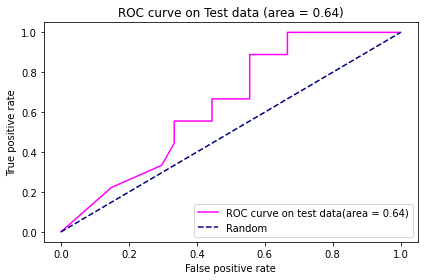

In [19]:
prediction_scores(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS)

Presicion - Recall auc on test data average score predictions: 0.42808078884575274
-----------------------------------------------------


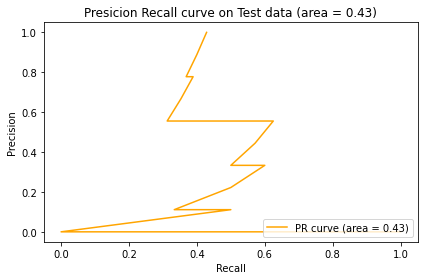

Presicion - Recall auc on test data maximum score predictions: 0.39202014713523664
-----------------------------------------------------


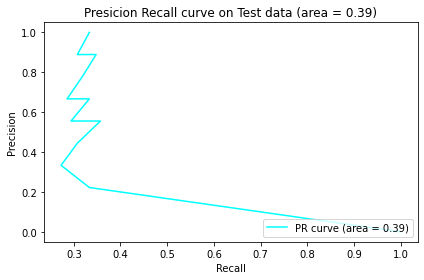

In [20]:
pre_recall(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS)

In [21]:
from sklearn.metrics import classification_report
AVG_LIST_PREDICTIONS = [round(x) for x in AVG_LIST_PREDICTIONS]
print("CLASSIFICATION REPORT")
print(classification_report(y_test_labels,AVG_LIST_PREDICTIONS))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.76      0.93      0.83        27
         1.0       0.33      0.11      0.17         9

    accuracy                           0.72        36
   macro avg       0.55      0.52      0.50        36
weighted avg       0.65      0.72      0.67        36



In [22]:
MAX_LIST_PREDICTIONS = [round(x) for x in MAX_LIST_PREDICTIONS]
print("CLASSIFICATION REPORT for MAX VALUE PREDICTIONS")
print(classification_report(y_test_labels,MAX_LIST_PREDICTIONS))

CLASSIFICATION REPORT for MAX VALUE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        27
         1.0       0.25      1.00      0.40         9

    accuracy                           0.25        36
   macro avg       0.12      0.50      0.20        36
weighted avg       0.06      0.25      0.10        36



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
#saving the model
model.save("fold3_resnet18_1000.h5")
!cp fold3_resnet18_1000.h5 "drive/My Drive/"